<h3>Import Libraries</h3>

In [2]:
# Importing libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from tensorflow.keras import models, optimizers, metrics
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from PIL import Image
import cv2
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
# Checking for GPUs
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
dir_path = r'D:\DataSets\brain_mri\brain_tumor_dataset'
yes_path = dir_path + r'\yes'
no_path = dir_path + r'\no'

<h2>Generating DataFrame

In [5]:
directories = [no_path, yes_path]
classes = ['No', 'Yes']
filepaths = []
labels = []

for i,j in zip(directories, classes):
    filelist = os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
        
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  253    labels:  253


In [6]:
files = pd.Series(filepaths, name='filepaths')
labels = pd.Series(labels, name='labels')
df = pd.concat([files,labels], axis=1)
df = pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])

In [7]:
df.head()

,filepaths,labels
0,D:\DataSets\brain_mri\brain_tumor_dataset\no\1...,No
1,D:\DataSets\brain_mri\brain_tumor_dataset\no\1...,No
2,D:\DataSets\brain_mri\brain_tumor_dataset\no\1...,No
3,D:\DataSets\brain_mri\brain_tumor_dataset\no\1...,No
4,D:\DataSets\brain_mri\brain_tumor_dataset\no\1...,No


In [8]:
df.tail()

,filepaths,labels
248,D:\DataSets\brain_mri\brain_tumor_dataset\yes\...,Yes
249,D:\DataSets\brain_mri\brain_tumor_dataset\yes\...,Yes
250,D:\DataSets\brain_mri\brain_tumor_dataset\yes\...,Yes
251,D:\DataSets\brain_mri\brain_tumor_dataset\yes\...,Yes
252,D:\DataSets\brain_mri\brain_tumor_dataset\yes\...,Yes


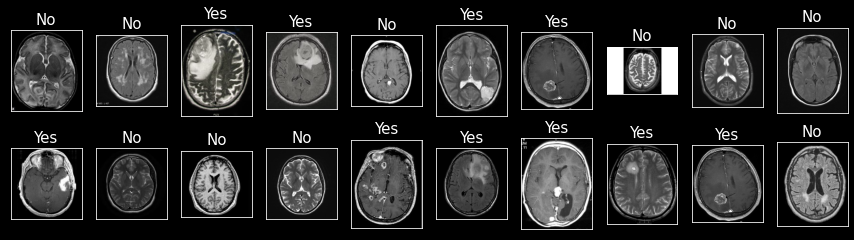

In [9]:
# images

plt.figure(figsize=(15,8))
for i in range(20):
    random = np.random.randint(1,len(df)) # view random images in dataframe
    plt.subplot(4,10,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
plt.show()

<h2>Generate Train, Test, Validation Set Splits

In [29]:
train, test = train_test_split(df, train_size=0.88, random_state=0) #split train test
train_new, valid = train_test_split(train, train_size=0.86, random_state=0) #split test validation

print(f"train set: {train_new.shape}")
print(f"test set: {test.shape}")
print(f"validation set: {valid.shape}")

train set: (190, 2)
test set: (31, 2)
validation set: (32, 2)


<h2>Augment Training Data & Generate Sets

In [30]:
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 30, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip =True)

test_datagen = ImageDataGenerator(
    rescale = 1.0/255.,
    )

In [31]:
train_generated = train_datagen.flow_from_dataframe(train_new, x_col = 'filepaths', 
                                              y_col ='labels',
                                              target_size = (224, 224), batch_size = 16,
                                              class_mode = 'binary', shuffle = True)
val_generated = test_datagen.flow_from_dataframe(valid, 
                                            target_size=(224, 224), x_col = 'filepaths', 
                                            y_col ='labels', batch_size= 16,
                                            class_mode='binary',
                                            shuffle=True)
test_generated = test_datagen.flow_from_dataframe(test,
                                            target_size = (224, 224), x_col = 'filepaths', y_col ='labels',
                                            class_mode = 'binary', batch_size= 16,
                                            shuffle = False)

Found 190 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.
Found 31 validated image filenames belonging to 2 classes.


In [32]:
train_generated.class_indices

{'No': 0, 'Yes': 1}

In [33]:
x_test, y_test = test_generated.next()

In [34]:
y_test # as seen float32 binary labels 

array([1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.],
      dtype=float32)

<br><h1>Building the Model

In [35]:
from tensorflow.keras.applications.vgg16 import VGG16

In [36]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [37]:
for layer in vgg_model.layers[:17]:  # leaves last conv layer unfrozen
    layer.trainable = False

for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 True
18 block5_pool True


In [38]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [39]:
model = Sequential()
model.add(vgg_model)

In [40]:
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation = 'softmax'))

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              25691136  
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               131200    
                                                                 
 dropout_5 (Dropout)         (None, 128)              

In [42]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Brain_Tumor_Classifier", save_best_only=True, verbose = 0),
    #tf.keras.callbacks.EarlyStopping(patience = 5, monitor='val_loss', verbose=1),
]

<h2>Training The Model

In [43]:
model.compile(loss = SparseCategoricalCrossentropy(), optimizer = Adam(), metrics = ['accuracy'])

In [44]:
history = model.fit(train_generated, validation_data = val_generated, epochs = 25, 
                    # callbacks = [callbacks]
                     verbose = 1)

Epoch 1/25
12/12 [==============================] - 9s 738ms/step - loss: 3.1768 - accuracy: 0.4895 - val_loss: 0.5768 - val_accuracy: 0.6562
Epoch 2/25
12/12 [==============================] - 3s 227ms/step - loss: 0.6682 - accuracy: 0.6263 - val_loss: 0.5743 - val_accuracy: 0.7188
Epoch 3/25
12/12 [==============================] - 3s 226ms/step - loss: 0.6240 - accuracy: 0.6684 - val_loss: 0.4150 - val_accuracy: 0.7812
Epoch 4/25
12/12 [==============================] - 3s 233ms/step - loss: 0.5869 - accuracy: 0.7105 - val_loss: 0.3604 - val_accuracy: 0.8438
Epoch 5/25
12/12 [==============================] - 3s 228ms/step - loss: 0.5771 - accuracy: 0.8053 - val_loss: 0.4731 - val_accuracy: 0.8438
Epoch 6/25
12/12 [==============================] - 3s 226ms/step - loss: 0.5086 - accuracy: 0.7526 - val_loss: 0.5033 - val_accuracy: 0.8125
Epoch 7/25
12/12 [==============================] - 3s 228ms/step - loss: 0.4880 - accuracy: 0.8000 - val_loss: 0.7375 - val_accuracy: 0.7188
Epoch 

<h2>Model Curves & Stats

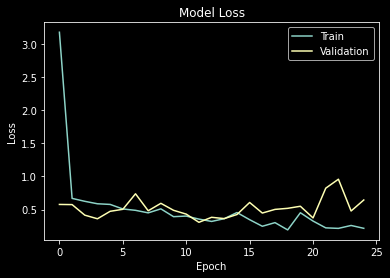

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

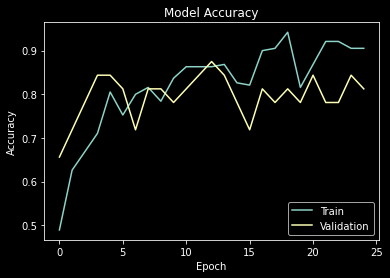

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [47]:
model.evaluate(test_generated)

2/2 [==============================] - 0s 158ms/step - loss: 0.0765 - accuracy: 0.9677


[0.07650431245565414, 0.9677419066429138]

In [48]:
model.save('Brain_Tumour.h5')

In [49]:
predictions = model.predict(test_generated)
predictions[:3]

array([[5.5572959e-03, 9.9444276e-01],
       [9.9996996e-01, 3.0039662e-05],
       [3.2158583e-04, 9.9967837e-01]], dtype=float32)

In [50]:
rounded_predictions = np.argmax(predictions, axis = -1)
y_pred = rounded_predictions

In [51]:
y_true = test_generated.classes

<h3>Generating Confusion Matrix

<AxesSubplot:>

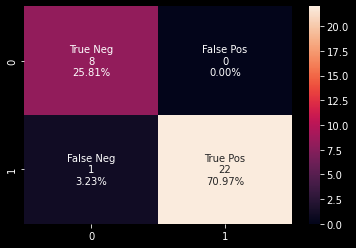

In [52]:
cf_matrix = confusion_matrix(y_true, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='')

<br><h1>Summary
    <p>...</p>